# Basic Analysis of a Binary Star  💫💫 # 


In this guide, you will learn how to: 
- Search for TESS light curves using the Lightkurve package 
- Stitch multiple light curves together
- Find the period of a binary star cycle using the Lightkurve
- Visualize changes in the orbit over time via phase-folding

Packages you will need: 
- numpy 
- matplotlib 
- astropy 
- scipy 
- lightkurve 

## 1. Import packages ## 
- Make sure you have them downloaded before starting

In [1]:
# let's import some packages 
# make sure you have them downloaded first! 

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
plt.style.use('seaborn-notebook')

import lightkurve as lk

## 2. Get the data ##
- Let's say we've already found a target of interest with coordinates ra = 91.98070326255153, dec = -66.3599094332912. 

- We can use these coordinates to search for it using the following command
- Here I specified the author already, but it doesn't need to be specified just yet 
- If there are multiple search results, that means multiple light curves were taken at different times, so we stitch them together 

In [2]:
author = 'QLP' # preprocessing by MIT Quick Look Pipeline 
search_result = lk.search_lightcurve('91.98070326255153 -66.3599094332912', author=author)
    
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,QLP,1800,41232835,0.0
1,TESS Sector 04,2018,QLP,1800,41232835,0.0
2,TESS Sector 07,2019,QLP,1800,41232835,0.0
3,TESS Sector 10,2019,QLP,1800,41232835,0.0
4,TESS Sector 11,2019,QLP,1800,41232835,0.0
5,TESS Sector 27,2020,QLP,600,41232835,0.0
...,...,...,...,...,...,...
15,TESS Sector 63,2023,QLP,200,41232835,0.0
16,TESS Sector 64,2023,QLP,200,41232835,0.0


In [3]:
# Note that our search object has multiple entries, representing multiple light curves. 
# Let's gather all the data and stitch them together into one giant light curve. 

target_name = '41232835' 
    
t_download = ((search_result.author.data == author))

light_curves = search_result[t_download].download_all()

lc = light_curves.stitch(corrector_func=lambda x: x.normalize())

In [4]:
# Let's look at the first 5 entries: 

lc[:5]

time,flux,flux_err,cadenceno,sap_flux,quality,orbitid,sap_x,sap_y,sap_bkg,sap_bkg_err
,,,,,,,pix,pix,,
Time,float32,float64,int32,float32,int32,int32,float32,float32,float32,float32
1325.3234660277578,0.8497300148010254,0.14142780005931854,4697,0.85070276,4096,9,2079.239990234375,1992.5980224609375,-1135.85,995.95
1325.344299320331,0.9267822504043579,0.14142780005931854,4698,0.9278432,4096,9,2079.239013671875,1992.593994140625,-1183.33,908.68
1325.3651326145061,1.0674176216125488,0.14142780005931854,4699,1.0686395,4096,9,2079.237060546875,1992.5870361328125,-739.22,825.37
1325.3859659102482,1.12057626247406,0.14142780005931854,4700,1.1218591,4096,9,2079.237060546875,1992.5860595703125,-827.22,735.4
1325.4067992075222,1.0453580617904663,0.14142780005931854,4701,1.0465548,4096,9,2079.238037109375,1992.5880126953125,-1104.7,745.14


<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

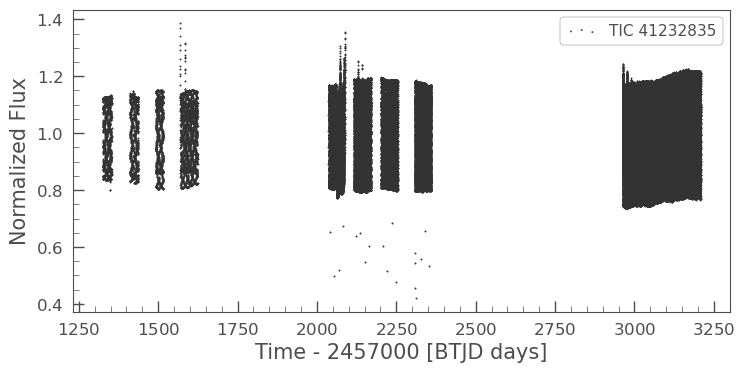

In [5]:
# this is what the entire lc looks like 
lc.scatter()

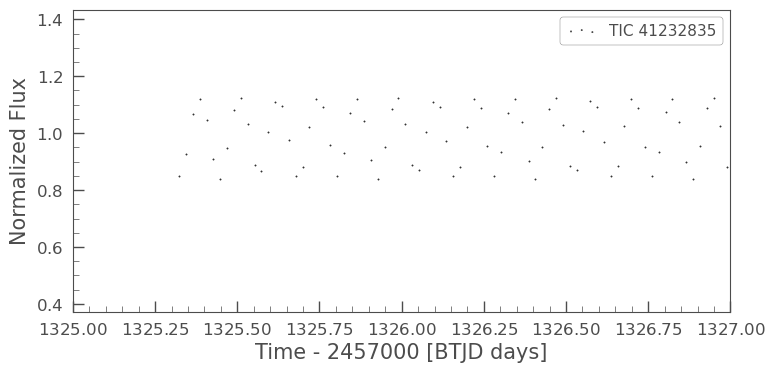

In [6]:
# we can zoom in
min = 1325
max = 1327

lc.scatter()
plt.xlim(min,max)
plt.show()

## 3. Clean the data ##

This is also a good time to explore different features of the data such as zooming in on different parts of the light curve and examining the metadata. 

In [7]:
# Filter the data so that we reduce some of the noise - put limits on the flux error value 
# Note that lc is an object in LightCurve object in Lightkurve

lcq = lc[lc['quality']==0]

print("Number of points left:", len(lcq))
print("Number of points eliminated:", len(lc) - len(lcq))

Number of points left: 120251
Number of points eliminated: 12994


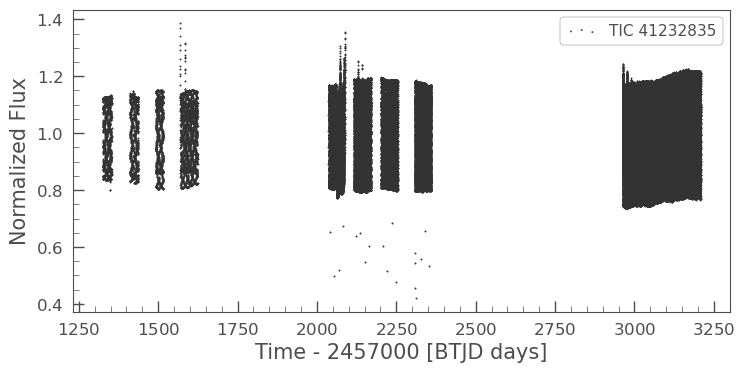

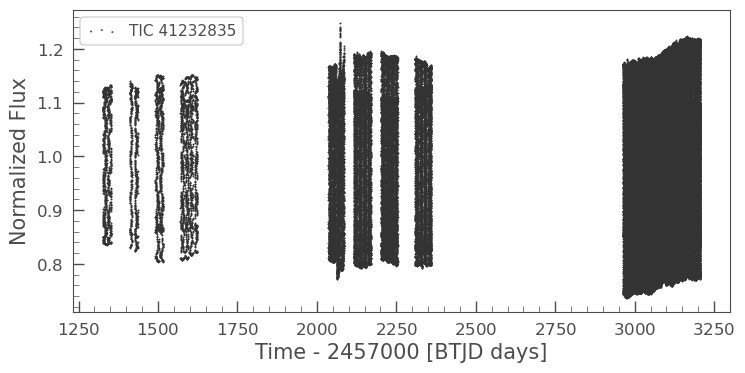

In [8]:
# compare before and after

lc.scatter() 
plt.show() 

lcq.scatter()
plt.show() 

## Estimate the orbital period ## 

Orbital period: time taken for both stars to complete one orbit (we measure in days) 

Frequency: orbits in a day

The period and frequency are related by the following equation:

$Frequency = 1/Period$

Looking at the zoomed in light curve above, we expect the period will be less than a day. There is a way to determine this more rigorously, and this is by using a periodogram. Essentially, what a periodogram does is similar to a Fourier Transform: it assigns relative strengths to possible period values and returns a graph. Luckily, lightkurve has a handy builtin function to do this! 

In [9]:
pg = lcq.normalize(unit='ppm').to_periodogram()
pg

LombScarglePeriodogram(ID: TIC 41232835)

<AxesSubplot:xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power [$\\mathrm{ppm}$]'>

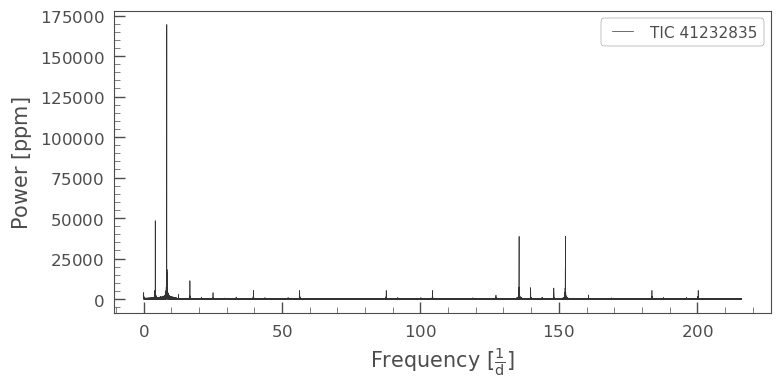

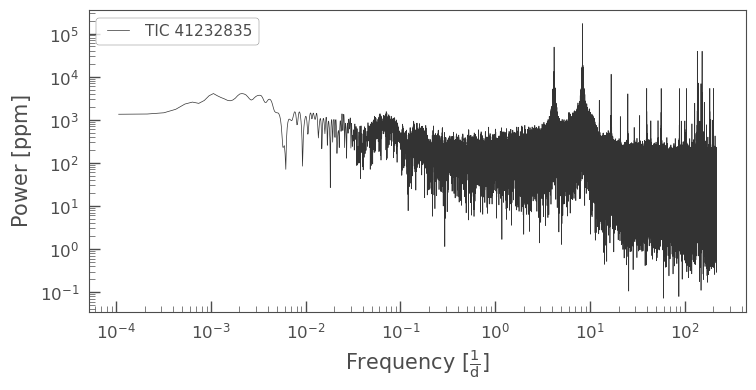

In [10]:
pg.plot()
pg.plot(scale='log')

0.11970561121532632 d


<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

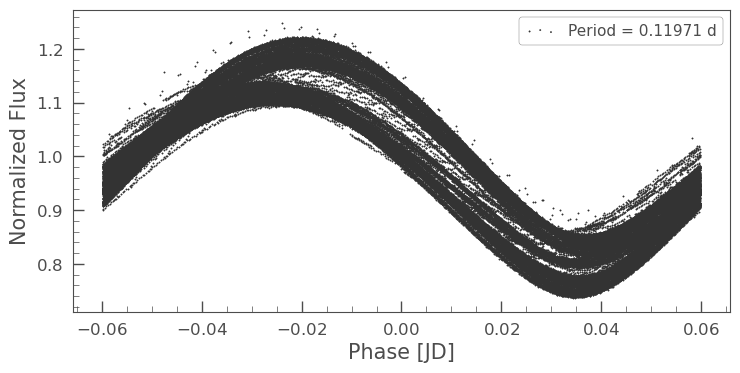

In [11]:
period = pg.period_at_max_power
print(period)
lcq.fold(period).scatter(label=f'Period = {period.value:.5f} d')

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

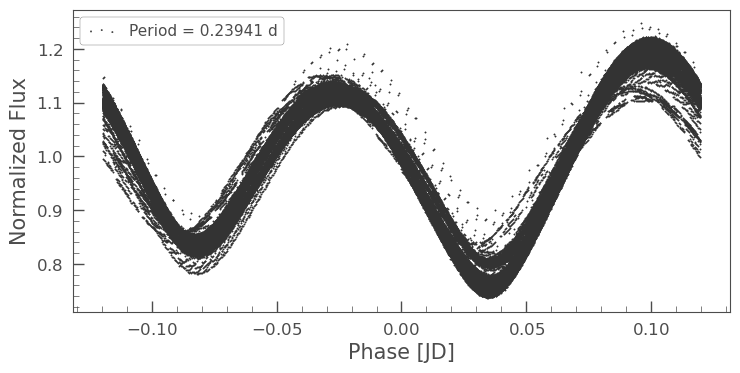

In [12]:
# try multiplying by 2 to account for both eclipses
period *= 2
lcq.fold(period).scatter(label=f'Period = {period.value:.5f} d')

Finding the period of this eclipsing binary is all good and well, but it’s not yet very precise, as the fold() plot indicates. Using keyword arguments of the to_periodogram() function, we can improve this estimate. Try one or both of the following: 
- Use the minimum_period and maximum_period arguments to limit the range of the periodogram to the area around the peak we are interested in. 
- Increase the oversample_factor argument from the default value of 1, which increases the resolution of the periodogram (this is at the expense of correlating the power values, but that is not a problem for the type of analysis we’re doing here).

<Quantity 0.23941228 d>

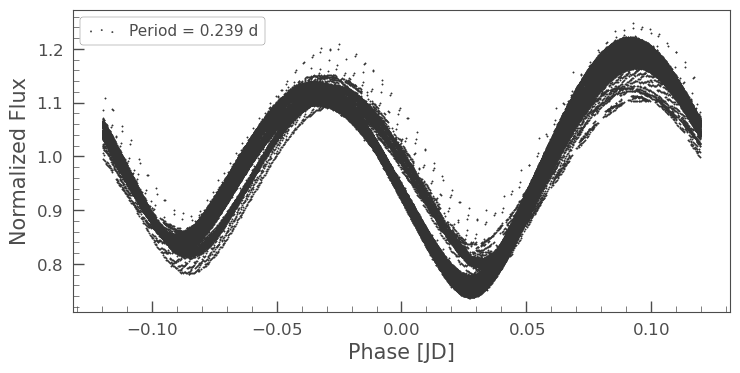

In [13]:
# Obtain a better estimate of the period

pg = lcq.to_periodogram(minimum_period = 0.239, maximum_period=0.240, oversample_factor=50)
new_period = pg.period_at_max_power

lcq.fold(new_period).scatter(label=f'Period = {period.value:.3f} d')
new_period

In [14]:
type(new_period), new_period.value, new_period.unit

(astropy.units.quantity.Quantity, 0.2394122772192037, Unit("d"))

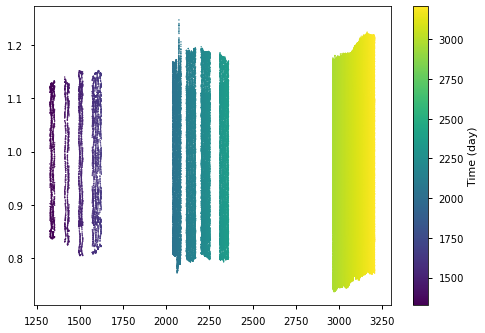

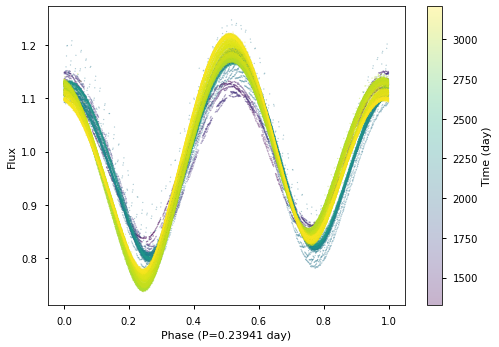

In [15]:
P = new_period.value
t = lcq['time'].value
x = (t%P)/P
y = lcq['flux'].value

# first plot 
plt.scatter(t,y, s=1, c=t)
plt.colorbar(label='Time (day)')
plt.show()

# second plot 
plt.scatter(x,y,s=1, c=t, alpha=0.3)
plt.colorbar(label='Time (day)')

plt.xlabel('Phase (P=%.5f day)' %(P))
plt.ylabel('Flux')
plt.show()

## Just for fun, an animation ## 

In [16]:
search_result = lk.search_targetpixelfile('91.98070326255153 -66.3599094332912')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,SPOC,120,41232835,0.0
1,TESS Sector 01,2018,TESS-SPOC,1800,41232835,0.0
2,TESS Sector 04,2018,SPOC,120,41232835,0.0
3,TESS Sector 04,2018,TESS-SPOC,1800,41232835,0.0
4,TESS Sector 07,2019,SPOC,120,41232835,0.0
5,TESS Sector 07,2019,TESS-SPOC,1800,41232835,0.0
...,...,...,...,...,...,...
27,TESS Sector 65,2023,TESS-SPOC,200,41232835,0.0
28,TESS Sector 66,2023,SPOC,120,41232835,0.0


In [17]:
tpf_file = search_result[33].download(quality_bitmask='default')
tpf_file.animate()

In [18]:
lk.show_citation_instructions()